In [27]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.io.pwscf import PWInput
from pymatgen.core import Structure
from pymatgen.analysis.elasticity import *
from pymatgen.io.vasp.inputs import *
from pymatgen.core.tensors import symmetry_reduce
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import os

from simtool import getValidatedInputs, DB, findInstalledSimToolNotebooks, searchForSimTool
import nanohubremote as nr

In [28]:
auth_data = { 'grant_type' : 'tool' }
with open(os.environ["SESSIONDIR"]+"/resources") as file:
    lines = [line.split(" ", 1) for line in file.readlines()]
    properties = {line[0].strip(): line[1].strip() for line in lines if len(line)==2}
    auth_data["sessiontoken"] = properties["session_token"]
    auth_data["sessionnum"] = properties["sessionid"]
    
session = nr.Session(auth_data, url='https://nanohub.org/api')

In [29]:
tool = 'elasticdft'

revisions = [0]

data_list = {}

for revision in revisions:
    search = {
            'tool':tool,
            'filters':json.dumps([
                                  {'field':'input.mp_id','operation':'==','value':'mp-8062'},
                                ]),
            'results':json.dumps([
                                'output.external_pressure',
                                'output.elastic_tensor',
                                'output.C11',
                                'output.C12',
                                'output.C44',
                                'output.homogeneous_poisson',
                                'output.bulk_modulus_voigt',
                                'output.bulk_modulus_reuss',
                                'output.bulk_modulus_vrh',
                                'output.shear_modulus_voigt',
                                'output.shear_modulus_reuss',
                                'output.shear_modulus_vrh',
                                'output.youngs_modulus'
                                ]),    
            'limit':10000,    
            'revision':revision,
            'simtool' : 1
             }

    req_json = session.requestPost('results/dbexplorer/search', data=search, timeout=60)
    req_json = req_json.json()
    data_list[f'{revision}'] = pd.DataFrame(req_json['results'])


data = pd.concat([data_list[f'{revision}'] for revision in revisions], axis=0, ignore_index=True)
data

,squid,revision,date,output.external_pressure,output.elastic_tensor,output.C11,output.C12,output.C44,output.homogeneous_poisson,output.bulk_modulus_voigt,output.bulk_modulus_reuss,output.bulk_modulus_vrh,output.shear_modulus_voigt,output.shear_modulus_reuss,output.shear_modulus_vrh,output.youngs_modulus
0,elasticdft/r13/12a4298cc263660e7db14ec53c55082...,13,2024-03-22 12:28:21.107634,-0.145,"[[390.18, 136.3, 136.26, 0, 1.1102230246252e-1...",390.18,136.36,244.49,0.168629,220.911111,220.911110,220.911110,197.460333,178.383411,187.921872,439.221748
1,elasticdft/r13/b6ee1f866a810d9eeffee7bca9ad758...,13,2024-03-22 12:29:25.61984,9.908,"[[428.02, 173.78, 173.92, -1.0487610779819e-14...",428.02,173.84,260.87,0.198106,258.577778,258.577781,258.577779,207.355333,183.576675,195.466004,468.378085
2,elasticdft/r13/a32c3e6e2ff27857d8359cc50807c2c...,13,2024-03-22 13:22:43.492762,49.956,"[[561.66, 315, 314.92, 0, -5.6843418860808e-14...",561.66,315.22,302.26,0.274421,397.193333,397.193333,397.193333,230.664000,191.168043,210.916022,537.591499
3,elasticdft/r13/4066f63dea964aacdae9fe1e6c54ee2...,13,2024-03-22 13:22:46.721244,19.909,"[[463.86, 210.4, 210.5, 3.5742075965572e-14, -...",463.86,210.48,274.22,0.222150,294.933333,294.933334,294.933334,215.214667,187.095542,201.155104,491.683411
4,elasticdft/r13/6405b5148901513dd0d4894c6ba7238...,13,2024-03-22 14:49:36.297156,100.010,"[[703.54, 479.14, 478.8, -1.1368683772162e-13,...",703.54,479.20,326.45,0.329612,553.826667,553.826685,553.826676,240.770667,185.060881,212.915774,566.190938
5,elasticdft/r13/1ac4d96d1f9724a1d2c3609e47e4fd0...,13,2024-03-25 06:37:06.157402,74.988,"[[633.54, 398.16, 398, -1.1368683772162e-13, 0...",633.54,398.18,316.70,0.305499,476.562222,476.562220,476.562221,237.101333,188.906089,213.003711,556.152097
6,elasticdft/r13/38ac716690c6d14b4c56b21b384304d...,13,2024-03-26 12:47:01.393006,-0.145,"[[390.18, 136.3, 136.24, 0, 1.1102230246252e-1...",390.18,136.36,244.49,0.168619,220.906667,220.906667,220.906667,197.463000,178.387055,187.925027,439.225541


In [31]:
c11_avg_ls = []
c12_avg_ls = []
c44_avg_ls = []
for i in range(len(data)):
    c11_avg = (data['output.elastic_tensor'][i][0][0] + data['output.elastic_tensor'][i][1][1] + data['output.elastic_tensor'][i][2][2])/3
    c12_avg = (data['output.elastic_tensor'][i][0][1] + data['output.elastic_tensor'][i][0][2] + data['output.elastic_tensor'][i][1][0] + 
               data['output.elastic_tensor'][i][2][0] + data['output.elastic_tensor'][i][2][1] + data['output.elastic_tensor'][i][1][2])/6
    c44_avg = (data['output.elastic_tensor'][i][3][3] + data['output.elastic_tensor'][i][4][4] + data['output.elastic_tensor'][i][5][5])/3
    c11_avg_ls.append(c11_avg)
    c12_avg_ls.append(c12_avg)
    c44_avg_ls.append(c44_avg)
    
data['C11_avg'] = c11_avg_ls
data['C12_avg'] = c12_avg_ls
data['C44_avg'] = c44_avg_ls

In [32]:
press = [0.2,2.2,6.65,16.5,26.7,35.5,45.5,56.9,65.6]
c11 = [399,425,410,458,487,539,554,601,672]
c12 = [133,135,147,167,213,263,278,313,339]
c44 = [251,270,257,298,299,315,314,329,316]
B = [225,232,235,264,304,355,370,409,450]

press_dft = [0,5,10,20,30,40,50]
c11_dft = [376.227,395.937,413.579,451.3,484.128,517.005,545.23]
c12_dft = [129.072,148.88,167.548,203.14,236.59,272.79,305.52]
c44_dft = [246.57,257.065,269.213,275.04,286.423,298.94,307.453]
B_dft = [211.45,231.23,249.9,286.24,319.109,352.59,385.471]
G_dft = [175,179.46,182.47,184.88,187.73,189.29,189.134]
Y_dft = [311.9,314.56,316.966,324.38,328.78,328.244,325.94]

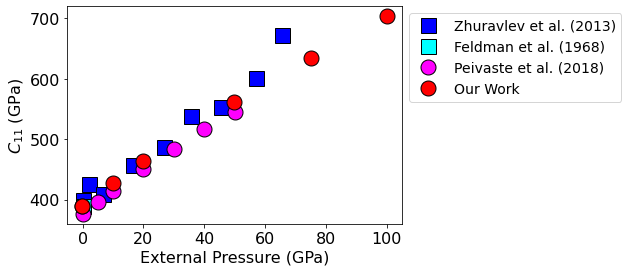

In [34]:
plt.plot(press,c11,'bs',markersize=15,markeredgecolor='k',label='Zhuravlev et al. (2013)')
plt.plot([0],[390],'s',color='cyan',markersize=15,markeredgecolor='k',label='Feldman et al. (1968)')
plt.plot(press_dft,c11_dft,'o',color='magenta',markersize=15,markeredgecolor='k',label='Peivaste et al. (2018)')
plt.plot(data['output.external_pressure'],data['C11_avg'],'ro',markersize=15,markeredgecolor='k',label='Our Work')
plt.ylabel('$C_{11}$ (GPa)',fontsize=16)
plt.xlabel('External Pressure (GPa)',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.show()

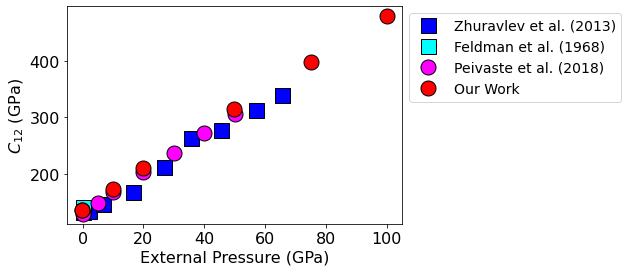

In [35]:
plt.plot(press,c12,'bs',markersize=15,markeredgecolor='k',label='Zhuravlev et al. (2013)')
plt.plot([0],[142],'s',color='cyan',markersize=15,markeredgecolor='k',label='Feldman et al. (1968)')
plt.plot(press_dft,c12_dft,'o',color='magenta',markersize=15,markeredgecolor='k',label='Peivaste et al. (2018)')
plt.plot(data['output.external_pressure'],data['C12_avg'],'ro',markersize=15,markeredgecolor='k',label='Our Work')
plt.ylabel('$C_{12}$ (GPa)',fontsize=16)
plt.xlabel('External Pressure (GPa)',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.show()

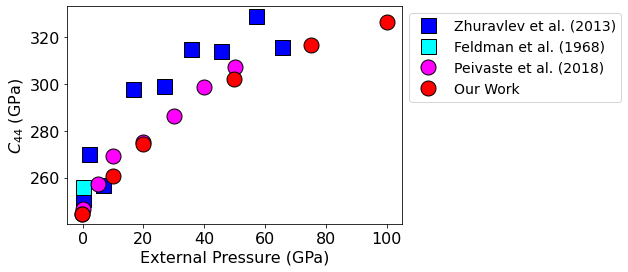

In [36]:
plt.plot(press,c44,'bs',markersize=15,markeredgecolor='k',label='Zhuravlev et al. (2013)')
plt.plot([0],[256],'s',color='cyan',markersize=15,markeredgecolor='k',label='Feldman et al. (1968)')
plt.plot(press_dft,c44_dft,'o',color='magenta',markersize=15,markeredgecolor='k',label='Peivaste et al. (2018)')
plt.plot(data['output.external_pressure'],data['C44_avg'],'ro',markersize=15,markeredgecolor='k',label='Our Work')
plt.ylabel('$C_{44}$ (GPa)',fontsize=16)
plt.xlabel('External Pressure (GPa)',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.show()

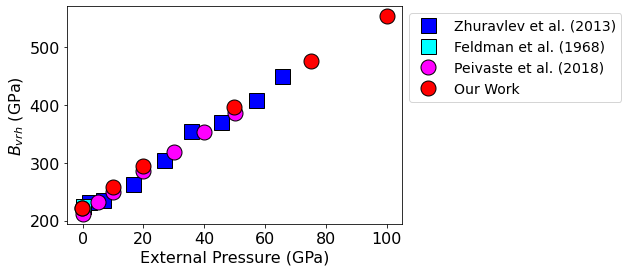

In [37]:
plt.plot(press,B,'bs',markersize=15,markeredgecolor='k',label='Zhuravlev et al. (2013)')
plt.plot([0],[225],'s',color='cyan',markersize=15,markeredgecolor='k',label='Feldman et al. (1968)')
plt.plot(press_dft,B_dft,'o',color='magenta',markersize=15,markeredgecolor='k',label='Peivaste et al. (2018)')
plt.plot(data['output.external_pressure'],data['output.bulk_modulus_vrh'],'ro',markersize=15,markeredgecolor='k',label='Our Work')
plt.ylabel('$B_{vrh}$ (GPa)',fontsize=16)
plt.xlabel('External Pressure (GPa)',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.show()

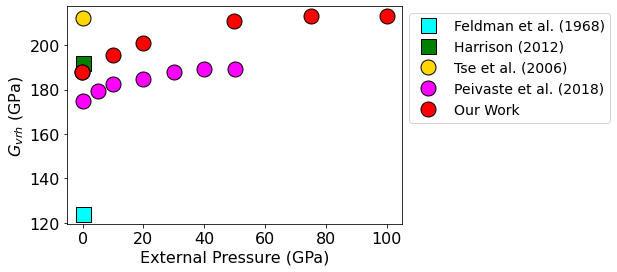

In [38]:
plt.plot([0],[124],'s',color='cyan',markersize=15,markeredgecolor='k',label='Feldman et al. (1968)')
plt.plot([0],[192],'gs',markersize=15,markeredgecolor='k',label='Harrison (2012)')
plt.plot([0],[212],'o',color='gold',markersize=15,markeredgecolor='k',label='Tse et al. (2006)')
plt.plot(press_dft,G_dft,'o',color='magenta',markersize=15,markeredgecolor='k',label='Peivaste et al. (2018)')
plt.plot(data['output.external_pressure'],data['output.shear_modulus_vrh'],'ro',markersize=15,markeredgecolor='k',label='Our Work')
plt.ylabel('$G_{vrh}$ (GPa)',fontsize=16)
plt.xlabel('External Pressure (GPa)',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.show()

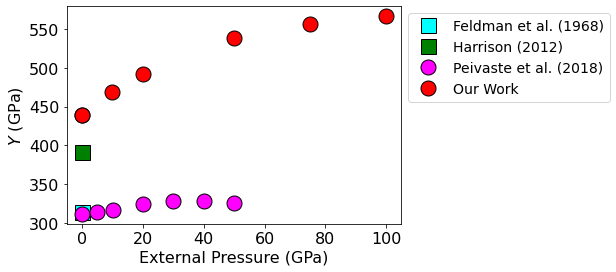

In [39]:
plt.plot([0],[314],'s',color='cyan',markersize=15,markeredgecolor='k',label='Feldman et al. (1968)')
plt.plot([0],[392],'gs',markersize=15,markeredgecolor='k',label='Harrison (2012)')
plt.plot(press_dft,Y_dft,'o',color='magenta',markersize=15,markeredgecolor='k',label='Peivaste et al. (2018)')
plt.plot(data['output.external_pressure'],data['output.youngs_modulus'],'ro',markersize=15,markeredgecolor='k',label='Our Work')
plt.ylabel('$Y$ (GPa)',fontsize=16)
plt.xlabel('External Pressure (GPa)',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14,bbox_to_anchor=(1,1))
plt.show()